Transfer Learning - VGG19 Cats and Dogs
    
    Feature Extraction    
    Fine-Tuning

In [1]:
import numpy as np
import pandas as pd
import os
%pylab inline
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


In [2]:
def format_data(path, path2, label, label2):
    files = os.listdir(path) 
    paths = [r"{}\{}".format(path,i) for i in files]
    
    files = os.listdir(path2) 
    paths2 = [r"{}\{}".format(path2,i) for i in files]
    
    df = pd.DataFrame(paths, columns=['Path'])
    df['Label'] = label
    
    df2 = pd.DataFrame(paths2, columns=['Path'])
    df2['Label'] = label2
    
    return df.append(df2).reset_index(drop=True)

In [3]:
train_cat_images_directory =  r"E:\Data\DogAndCats\cats_and_dogs_filtered\train\cats"
train_dog_images_directory =  r"E:\Data\DogAndCats\cats_and_dogs_filtered\train\dogs"

train_df = format_data(path=train_cat_images_directory,
                       path2=train_dog_images_directory,
                       label="cat",
                       label2="dog")

val_cat_images_directory =  r"E:\Data\DogAndCats\cats_and_dogs_filtered\validation\cats"
val_dog_images_directory =  r"E:\Data\DogAndCats\cats_and_dogs_filtered\validation\dogs"

val_df = format_data(path=val_cat_images_directory,
                       path2=val_dog_images_directory,
                       label="cat",
                       label2="dog")

In [4]:
train_df.head()

,Path,Label
0,E:\Data\DogAndCats\cats_and_dogs_filtered\trai...,cat
1,E:\Data\DogAndCats\cats_and_dogs_filtered\trai...,cat
2,E:\Data\DogAndCats\cats_and_dogs_filtered\trai...,cat
3,E:\Data\DogAndCats\cats_and_dogs_filtered\trai...,cat
4,E:\Data\DogAndCats\cats_and_dogs_filtered\trai...,cat


cat


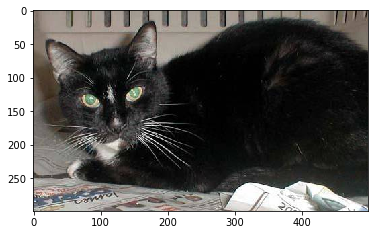

In [5]:
plt.imshow(imread(train_df['Path'][123]))
print(train_df['Label'][123])

### VGG19 Architecture
https://www.tensorflow.org/alpha/tutorials/images/transfer_learning

In [6]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers

In [7]:
IMG_SHAPE = (150, 150, 3)

base_model = tf.keras.applications.VGG19(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

x = base_model.output
x = layers.Flatten()(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.BatchNormalization()(x)
predictions = layers.Dense(2, activation='sigmoid')(x)

model = models.Model(base_model.input, predictions)

model.trainable = True

Instructions for updating:
Colocations handled automatically by placer.


In [8]:
model.layers[:22]

In [9]:
for layer in model.layers[:22]:
    layer.trainable = False

In [10]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [11]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255, 
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(rescale=1./255)

In [13]:
train_generator = train_datagen.flow_from_dataframe(dataframe=train_df,
                                                      x_col="Path", 
                                                      y_col="Label", 
                                                      target_size=(150,150),
                                                      class_mode="categorical",
                                                      batch_size=32)

validation_generator = validation_datagen.flow_from_dataframe(dataframe=val_df,
                                                                x_col="Path", 
                                                                y_col="Label", 
                                                                target_size=(150,150),
                                                                class_mode="categorical",
                                                                batch_size=32)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [35]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=50  
)

Epoch 1/30
100/100 [==============================] - 38s 384ms/step - loss: 0.5456 - accuracy: 0.7317 - val_loss: 0.4117 - val_accuracy: 0.8274
Epoch 2/30
100/100 [==============================] - 26s 259ms/step - loss: 0.4374 - accuracy: 0.7987 - val_loss: 0.3188 - val_accuracy: 0.8664
Epoch 3/30
100/100 [==============================] - 26s 258ms/step - loss: 0.3871 - accuracy: 0.8235 - val_loss: 0.3012 - val_accuracy: 0.8683
Epoch 4/30
100/100 [==============================] - 26s 257ms/step - loss: 0.3505 - accuracy: 0.8433 - val_loss: 0.2770 - val_accuracy: 0.8817
Epoch 5/30
100/100 [==============================] - 26s 256ms/step - loss: 0.3549 - accuracy: 0.8470 - val_loss: 0.2916 - val_accuracy: 0.8747
Epoch 6/30
100/100 [==============================] - 27s 273ms/step - loss: 0.3409 - accuracy: 0.8510 - val_loss: 0.2892 - val_accuracy: 0.8721
Epoch 7/30
100/100 [==============================] - 26s 257ms/step - loss: 0.3322 - accuracy: 0.8573 - val_loss: 0.2960 - val_ac

In [36]:
model.save_weights("vgg19_cats_and_dogs_fe.h5py")

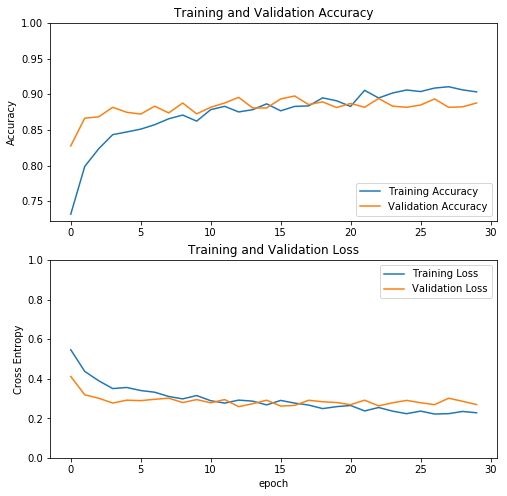

In [37]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [25]:
model.layers[:12]

In [26]:
for layer in model.layers:
    layer.trainable =  True
print("Number of layers in the base model: ", len(model.layers))

# Fine tune from this layer onwards
fine_tune_at = 12

#Freeze all the layers before the `fine_tune_at` layer
for layer in model.layers[:fine_tune_at]:
    layer.trainable =  False

Number of layers in the base model:  27


In [14]:
model.load_weights("vgg19_cats_and_dogs_fe.h5py")
model.compile(loss='binary_crossentropy',
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])

In [28]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [29]:
fine_tune_epochs = 10
total_epochs =  30 + fine_tune_epochs

In [30]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint(filepath="VGG19_CAT_AND_DOGS_BEST.h5py",monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
callbacks = [checkpoint]

In [31]:
history_fine = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=total_epochs,
    validation_data=validation_generator,
    validation_steps=50,
    callbacks=callbacks
)

Epoch 1/40
 99/100 [============================>.] - ETA: 0s - loss: 0.2378 - accuracy: 0.9016
Epoch 00001: val_loss improved from inf to 0.34139, saving model to VGG19_CAT_AND_DOGS_BEST.h5py
100/100 [==============================] - 31s 313ms/step - loss: 0.2388 - accuracy: 0.9015 - val_loss: 0.3414 - val_accuracy: 0.8912
Epoch 2/40
 99/100 [============================>.] - ETA: 0s - loss: 0.1761 - accuracy: 0.9273
Epoch 00002: val_loss improved from 0.34139 to 0.21797, saving model to VGG19_CAT_AND_DOGS_BEST.h5py
100/100 [==============================] - 27s 271ms/step - loss: 0.1755 - accuracy: 0.9279 - val_loss: 0.2180 - val_accuracy: 0.9188
Epoch 3/40
 99/100 [============================>.] - ETA: 0s - loss: 0.1752 - accuracy: 0.9326
Epoch 00003: val_loss improved from 0.21797 to 0.17458, saving model to VGG19_CAT_AND_DOGS_BEST.h5py
100/100 [==============================] - 27s 272ms/step - loss: 0.1752 - accuracy: 0.9323 - val_loss: 0.1746 - val_accuracy: 0.9337
Epoch 4/40


100/100 [==============================] - 28s 281ms/step - loss: 0.0374 - accuracy: 0.9877 - val_loss: 0.0983 - val_accuracy: 0.9667
Epoch 29/40
 99/100 [============================>.] - ETA: 0s - loss: 0.0329 - accuracy: 0.9892
Epoch 00029: val_loss did not improve from 0.09827
100/100 [==============================] - 27s 269ms/step - loss: 0.0328 - accuracy: 0.9893 - val_loss: 0.2084 - val_accuracy: 0.9350
Epoch 30/40
 99/100 [============================>.] - ETA: 0s - loss: 0.0335 - accuracy: 0.9901
Epoch 00030: val_loss did not improve from 0.09827
100/100 [==============================] - 27s 265ms/step - loss: 0.0333 - accuracy: 0.9902 - val_loss: 0.1177 - val_accuracy: 0.9635
Epoch 31/40
 99/100 [============================>.] - ETA: 0s - loss: 0.0296 - accuracy: 0.9900
Epoch 00031: val_loss did not improve from 0.09827
100/100 [==============================] - 27s 268ms/step - loss: 0.0293 - accuracy: 0.9901 - val_loss: 0.1228 - val_accuracy: 0.9546
Epoch 32/40
 99/100 

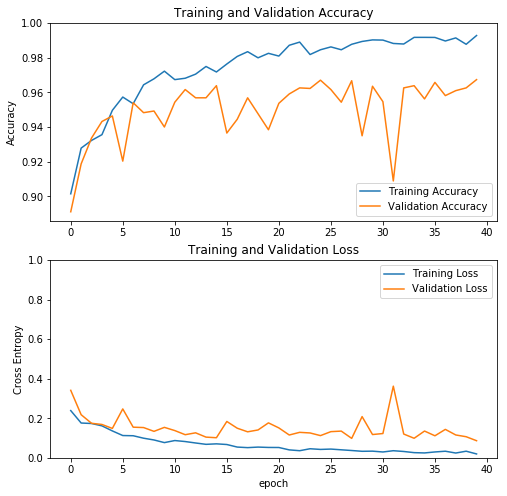

In [34]:
acc = history_fine.history['accuracy']
val_acc = history_fine.history['val_accuracy']

loss = history_fine.history['loss']
val_loss = history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [35]:
model.save_weights("vgg19_cats_and_dogs_ft.h5py")

In [23]:
model.load_weights("VGG19_CAT_AND_DOGS_BEST.h5py")

In [24]:
val_loss, val_acc = model.evaluate_generator(validation_generator, steps=50)

In [25]:
print("Validation loss:", val_loss)
print("Validation accuracy:", val_acc)

Validation loss: 0.09279498577961931
Validation accuracy: 0.965
